## Logistic/Softmax Regression
A simple multi-event classifier model to predict activity type.

Resources: 
- https://www.skytowner.com/explore/comprehensive_guide_on_logistic_regression

1. Load data

In [4]:
from pathlib import Path
import polars as pl

from lisa.config import PROCESSED_DATA_DIR

input_path: Path = PROCESSED_DATA_DIR / "labelled_test_data.csv"

df = pl.read_csv(input_path)

df

TRIAL,TIME,first_Right Foot Sensor.RFS,last_Right Foot Sensor.RFS,max_Right Foot Sensor.RFS,min_Right Foot Sensor.RFS,mean_Right Foot Sensor.RFS,std_Right Foot Sensor.RFS,first_Left Foot Sensor.LFS,last_Left Foot Sensor.LFS,max_Left Foot Sensor.LFS,min_Left Foot Sensor.LFS,mean_Left Foot Sensor.LFS,std_Left Foot Sensor.LFS,first_Global Angle_Foot_L.x,last_Global Angle_Foot_L.x,max_Global Angle_Foot_L.x,min_Global Angle_Foot_L.x,mean_Global Angle_Foot_L.x,std_Global Angle_Foot_L.x,first_Global Angle_Foot_L.y,last_Global Angle_Foot_L.y,max_Global Angle_Foot_L.y,min_Global Angle_Foot_L.y,mean_Global Angle_Foot_L.y,std_Global Angle_Foot_L.y,first_Global Angle_Foot_L.z,last_Global Angle_Foot_L.z,max_Global Angle_Foot_L.z,min_Global Angle_Foot_L.z,mean_Global Angle_Foot_L.z,std_Global Angle_Foot_L.z,first_HighG_Foot_L.x,last_HighG_Foot_L.x,max_HighG_Foot_L.x,min_HighG_Foot_L.x,mean_HighG_Foot_L.x,…,first_gyro_Foot_R.x,last_gyro_Foot_R.x,max_gyro_Foot_R.x,min_gyro_Foot_R.x,mean_gyro_Foot_R.x,std_gyro_Foot_R.x,first_gyro_Foot_R.y,last_gyro_Foot_R.y,max_gyro_Foot_R.y,min_gyro_Foot_R.y,mean_gyro_Foot_R.y,std_gyro_Foot_R.y,first_gyro_Foot_R.z,last_gyro_Foot_R.z,max_gyro_Foot_R.z,min_gyro_Foot_R.z,mean_gyro_Foot_R.z,std_gyro_Foot_R.z,first_mag_Foot_R.x,last_mag_Foot_R.x,max_mag_Foot_R.x,min_mag_Foot_R.x,mean_mag_Foot_R.x,std_mag_Foot_R.x,first_mag_Foot_R.y,last_mag_Foot_R.y,max_mag_Foot_R.y,min_mag_Foot_R.y,mean_mag_Foot_R.y,std_mag_Foot_R.y,first_mag_Foot_R.z,last_mag_Foot_R.z,max_mag_Foot_R.z,min_mag_Foot_R.z,mean_mag_Foot_R.z,std_mag_Foot_R.z,ACTIVITY
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,299,3.661904,2.485147,3.673196,2.432046,2.696399,0.34669,1.908885,3.316051,3.318797,1.868602,2.499939,0.424515,0.747913,0.877581,0.877581,0.747172,0.790992,0.039549,1.414698,1.343655,1.414698,1.343655,1.389949,0.017417,2.41077,2.55737,2.55737,2.41077,2.481752,0.031752,23.918659,4.377114,23.918659,0.956746,4.800475,…,4.305908,-1.062314,4.305908,-3.178707,-0.892377,2.330771,1.386873,-0.828123,1.581352,-2.376107,-0.593655,1.116945,-11.092124,6.665078,8.915559,-11.465845,4.117846,6.546186,-0.000013,0.000024,0.000024,-0.000016,-0.000003,0.000012,-0.00001,-0.000018,0.000008,-0.000019,-0.000004,0.00001,0.000003,-0.000004,0.000009,-0.000004,0.000002,0.000004,"""walk"""
0,300,3.644509,2.478738,3.673196,2.432046,2.692455,0.342372,1.8921,3.321239,3.321239,1.868602,2.504647,0.425768,0.74788,0.878598,0.878598,0.747172,0.791427,0.039792,1.413869,1.343154,1.413869,1.343154,1.389711,0.017566,2.412725,2.558105,2.558105,2.412725,2.482243,0.03179,23.033669,4.305358,23.033669,0.956746,4.735097,…,4.265439,-1.084354,4.265439,-3.178707,-0.910345,2.311259,1.373026,-0.744837,1.581352,-2.376107,-0.600761,1.111068,-11.173891,6.571081,8.915559,-11.465845,4.176724,6.488103,-0.000013,0.000024,0.000024,-0.000016,-0.000003,0.000012,-0.00001,-0.000018,0.000008,-0.000019,-0.000004,0.00001,0.000003,-0.000004,0.000009,-0.000004,0.000002,0.000004,"""walk"""
0,301,3.673196,2.463479,3.673196,2.432046,2.688519,0.338153,1.868602,3.363658,3.363658,1.868602,2.509552,0.427162,0.747848,0.879787,0.879787,0.747172,0.791867,0.040037,1.413039,1.342672,1.413039,1.342672,1.389473,0.017719,2.41468,2.558743,2.558743,2.41468,2.48273,0.031839,22.148678,4.424952,22.148678,0.956746,4.673068,…,4.224969,-1.106393,4.224969,-3.178707,-0.928251,2.291753,1.359179,-0.661551,1.581352,-2.376107,-0.607543,1.105174,-11.255657,6.477084,8.915559,-11.465845,4.23556,6.428188,-0.000013,0.000024,0.000024,-0.000016,-0.000003,0.000012,-0.000009,-0.000018,0.000008,-0.000019,-0.000004,0.00001,0.000003,-0.000004,0.000009,-0.000004,0.000002,0.000004,"""walk"""
0,302,3.632607,2.461343,3.656716,2.432046,2.684479,0.333558,1.886607,3.339244,3.363658,1.886607,2.514454,0.428219,

2. Train/Test Split

In [5]:
from lisa.modeling.logistic_regression import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, train_size=0.8, gap=300)

print('Train: ')
print(y_train.to_series().value_counts())
print('Test: ')
print(y_test.to_series().value_counts())

Train: 
shape: (4, 2)
┌──────────┬────────┐
│ ACTIVITY ┆ count  │
│ ---      ┆ ---    │
│ str      ┆ u32    │
╞══════════╪════════╡
│ run      ┆ 55043  │
│ jog      ┆ 236620 │
│ walk     ┆ 463628 │
│ jump     ┆ 15043  │
└──────────┴────────┘
Test: 
shape: (4, 2)
┌──────────┬────────┐
│ ACTIVITY ┆ count  │
│ ---      ┆ ---    │
│ str      ┆ u32    │
╞══════════╪════════╡
│ jog      ┆ 58855  │
│ run      ┆ 13461  │
│ jump     ┆ 3461   │
│ walk     ┆ 115607 │
└──────────┴────────┘


3. Feature scaling

In [6]:
from lisa.modeling.logistic_regression import standard_scaler


X_train, X_test, scaler = standard_scaler(X_train, X_test)

4. Logistic regression

In [7]:
from lisa.modeling.logistic_regression import logistic_regression


logisticRegr = logistic_regression(X_train, y_train)

In [8]:
predictions = logisticRegr.predict(X_test)

5. Measure performance

In [9]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.9606079923086569


Text(0.5, 1.0, 'Accuracy Score: 0.9606079923086569')

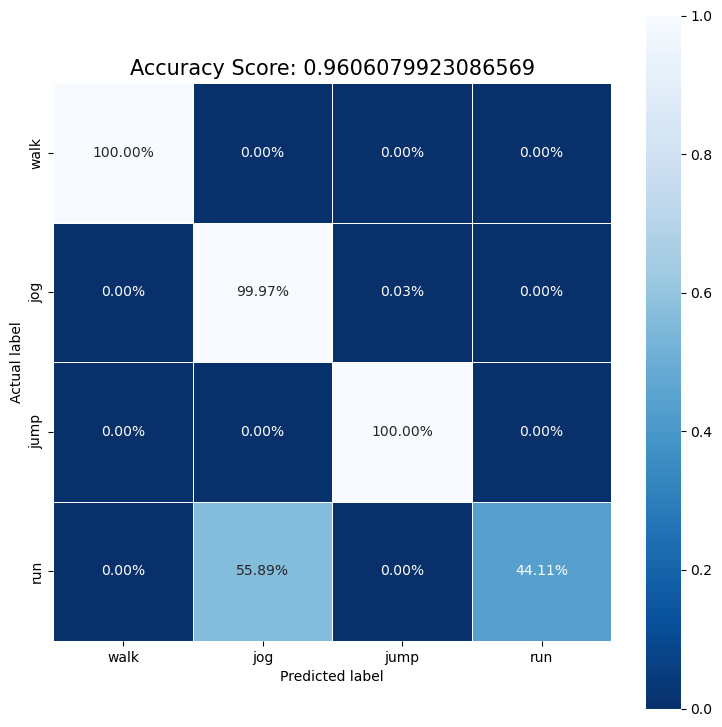

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

labels = df['ACTIVITY'].unique(maintain_order=True)
cm = metrics.confusion_matrix(y_test, predictions, labels=labels, normalize='true')

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {score}'
plt.title(all_sample_title, size = 15)

In [11]:
# import numpy as np
# # Coefficients and Odds Ratios
# coefficients = logisticRegr.coef_[0]
# odds_ratios = np.exp(coefficients)


# # Display feature importance using coefficients and odds ratios
# feature_importance = pl.DataFrame({
#     'Feature': df.select(pl.exclude(["ACTIVITY","TRIAL", "TIME"])).columns,
#     'Coefficient': coefficients,
#     'Odds Ratio': odds_ratios
# })
# print("\nFeature Importance (Coefficient and Odds Ratio):")
# print(feature_importance.sort(by='Coefficient', descending=True))

In [12]:
# from sklearn.inspection import permutation_importance

# # Permutation Importance
# perm_importance = permutation_importance(logisticRegr, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
# perm_importance_df = pl.DataFrame({
#     'Feature': df.select(pl.exclude(["ACTIVITY","TRIAL", "TIME"])).columns,
#     'Importance Mean': perm_importance.importances_mean,
#     'Importance Std': perm_importance.importances_std
# })

# print("\nPermutation Importance:")
# print(perm_importance_df.sort(by='Importance Mean', descending=True))
